# ***Import Statements for libraries***

In [1]:
import numpy as np
import pandas as pd
import wordcloud
import seaborn as sns
import matplotlib.pyplot as plt


from keras import backend as K

from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.models import Sequential
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding,concatenate, Bidirectional
from keras.layers import Dropout, Input, LeakyReLU, Conv1D, GlobalMaxPooling1D,InputLayer, ReLU, LSTM


#Utils
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from keras.utils import vis_utils
from sklearn.manifold import TSNE

#!pip3 install keras_metrics
import tensorflow as tf
from tensorflow.python.keras.metrics import Metric
from tensorflow.keras.optimizers import Adam

import io
from google.colab import files


In [2]:
#metrics
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#Classifiers 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Time and counters
from time import perf_counter

#grid search of params
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

# NLP lib
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk import flatten , PorterStemmer, WordNetLemmatizer, FreqDist
from collections import Counter

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

#Mark Down print
from IPython.display import Markdown, display
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
# File optimization
import h5py


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append("drive/MyDrive/Glove/")
!ls
from utils import *
"""
printmd, get_confusion_matrix_heatmap, ROC_AUC, Word_Embeddings_visualise_TSNE, 
read_glove_vecs, X_to_index, sentences_to_indices, get_Metrics, 
pretrained_embedding_layer,  ANN_with_glove, RNN_with_glove, CNN_with_glove
ANN_with_glove_architecture_2
""" 

drive  sample_data


'\nprintmd, get_confusion_matrix_heatmap, ROC_AUC, Word_Embeddings_visualise_TSNE, \nread_glove_vecs, X_to_index, sentences_to_indices, get_Metrics, \npretrained_embedding_layer,  ANN_with_glove, RNN_with_glove, CNN_with_glove\nANN_with_glove_architecture_2\n'

In [5]:
#Paths

#Paths

heatmaps = "drive/MyDrive/Glove/heatmaps/"
Visuals = "drive/MyDrive/Glove/Visuals/"
Glove   = "drive/MyDrive/Glove/"
Model   = "drive/MyDrive/Glove/Model/"
print(f'{Model}Augmented_emails.csv')

drive/MyDrive/Glove/Model/Augmented_emails.csv


# **Data Test Train Split for hyper-parameter tuning of : KNN and Gradient boosting**



In [6]:
#Test Train Split of Data
# load data

# uploaded = files.upload()
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

data = pd.read_csv(f'{Glove}Augmented_emails.csv')

#Label
data['spam'] = [1 if x == 1.0 else 0 for x in data['spam']]

#remove duplicated data
print(f"duplicated entries {data.duplicated().sum()}\n")
data = data.drop_duplicates()
print(f"duplicated entries {data.duplicated().sum()}\n")

#remove Null values
print("Number of null features in the dataset :")
print(f"{data.isnull().sum()}\n")

data.dropna(subset=["spam"], inplace=True)

print("Number of null features in the dataset :")
print(f"{data.isnull().sum()}")
print()

print(f"shape of the dataset : {data.shape}, Number of rows and columns : {data.shape[0]} , {data.shape[1]}\n")

# Convert data to H5py file 
data.to_hdf(f'{Glove}data_embeddings.h5', 'data', mode='w',format='table',data_columns=True)

data = pd.read_hdf(f'{Glove}data_embeddings.h5', 'data')
data = pd.DataFrame(data)
#Make a copy of the data set.
data_ANN_RNN_CNN = data.copy()

data.head(10)



duplicated entries 0

duplicated entries 0

Number of null features in the dataset :
X       2
spam    0
dtype: int64

Number of null features in the dataset :
X       2
spam    0
dtype: int64

shape of the dataset : (5495, 2), Number of rows and columns : 5495 , 2



,X,spam
0,naturally irresistible corporate identity real...,1
1,stock trading gunslinger fanny merrill muzo co...,1
2,unbelievable home made easy wanting show homeo...,1
3,color printing special request additional info...,1
4,money software software compatibility great gr...,1
5,great nnews hello welcome medzonline groundsel...,1
6,play motion homeland security investment terro...,1
7,save money getting thing tried cialls even ima...,1
8,undeliverable home based business grownup mess...,1
9,save money getting thing tried cialls even ima...,1


In [7]:
#Splitting the data - 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(data["X"] , data["spam"], test_size = 0.2, random_state = 99)
print(f"Training split input: {X_train.shape}")
print(f"Testing split input : {X_test.shape}")
print(f"Training split class: {y_train.shape}")
print(f"Testing split class : {y_test.shape}")

print(X_train.dtypes)
print(X_test.dtypes)
print(y_train.dtypes)
print(y_test.dtypes)

#TF IDF - vectorisation of data , feature extraction
tfidf = TfidfVectorizer()
X_train_vect = tfidf.fit_transform(X_train.values.astype('U'))
X_test_vect = tfidf.transform(X_test.values.astype('U'))

# Get feature names in the vector
#tfidf.get_feature_names()

X_train_vect.toarray()
print(f"Training data shape : {X_train_vect.shape}")
X_test_vect.toarray()
print(f"Testing data shape : {X_test_vect.shape}")

Training split input: (4396,)
Testing split input : (1099,)
Training split class: (4396,)
Testing split class : (1099,)
object
object
int64
int64
Training data shape : (4396, 28166)
Testing data shape : (1099, 28166)


# **GPU Support**

In [8]:
"""
GPU support
"""
#' ' means CPU whereas '/device:G:0' means GPU

tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=2f58814ac64dfbdfd5394b2fa4f04f3d116471197d5ef5d2f07cbc69e2d31895
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 25.9 GB  | Proc size: 1.9 GB
GPU RAM Free: 15935MB | Used: 345MB | Util   2% | Total 16280MB


In [10]:
# !kill -9 -1
# kill the machine

In [11]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.5199568259999978
GPU (s):
0.032652517999849806
GPU speedup over CPU: 46x


# KNN - K nearest neighbours

# **Hyper parameter tuning : **
1.   leaf size
2.   n_neighbours
3.   P









In [12]:
"""
KNN()

# Find the best hyperparameter with GridSearchCV
# Exhaustive search over specified parameter values for an estimator.

#List Hyperparameters that we want to tune.
leaf_size = [5,10,15,20,25,30]
n_neighbors = [5,10,15,20,25,30]
p=[1,2]

# #Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

# #Use GridSearch
grid = GridSearchCV(KNeighborsClassifier(), param_grid=hyperparameters, cv=10)
# #Fit the model
with tf.device('/device:GPU:0'):
  grid.fit(X_train_vect,y_train)

# # Create a DataFrame with the best Hyperparameters
KNN_hyperparameter_tuned = pd.DataFrame(grid.cv_results_)[['params','mean_test_score']]\
                               .sort_values(by="mean_test_score", ascending=False)

KNN_hyperparameter_tuned.to_csv("drive/MyDrive/SPAM classification deep learning/Visuals/KNN_hyperparameters.csv")
"""

# KNN_hyperparameter_tuned = pd.read_csv("drive/MyDrive/SPAM classification deep learning/Visuals/KNN_hyperparameters.csv")
# KNN_hyperparameter_tuned

'\nKNN()\n\n# Find the best hyperparameter with GridSearchCV\n# Exhaustive search over specified parameter values for an estimator.\n\n#List Hyperparameters that we want to tune.\nleaf_size = [5,10,15,20,25,30]\nn_neighbors = [5,10,15,20,25,30]\np=[1,2]\n\n# #Convert to dictionary\nhyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)\n\n# #Use GridSearch\ngrid = GridSearchCV(KNeighborsClassifier(), param_grid=hyperparameters, cv=10)\n# #Fit the model\nwith tf.device(\'/device:GPU:0\'):\n  grid.fit(X_train_vect,y_train)\n\n# # Create a DataFrame with the best Hyperparameters\nKNN_hyperparameter_tuned = pd.DataFrame(grid.cv_results_)[[\'params\',\'mean_test_score\']]                               .sort_values(by="mean_test_score", ascending=False)\n\nKNN_hyperparameter_tuned.to_csv("drive/MyDrive/SPAM classification deep learning/Visuals/KNN_hyperparameters.csv")\n'

In [13]:
# Plot grid Seach results
# print(grid.cv_results_)
# scores = [x[1] for x in grid.cv_results_]
# print(scores)
# scores = np.array(scores).reshape(len(leaf_size), len(n_neighbors))

# for ind, i in enumerate(leaf_size):
#     plt.plot(n_neighbors, scores[ind], label='C: ' + str(i))
# plt.legend()
# plt.xlabel('n neighbors')
# plt.ylabel('Mean score')
# plt.show()
# plt.savefig("drive/MyDrive/SPAM classification deep learning/Visuals/KNN_Grid_search.jpeg")

In [14]:

# Display the best hyperparameters
# grid.best_params_
# best_params = {'leaf_size': 5, 'n_neighbors': 5, 'p': 2}
# print(best_params)

In [15]:
# leaf_size, n_neighbors, p = best_params['leaf_size'], best_params['n_neighbors'], best_params['p']
# model = KNeighborsClassifier(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

# model.fit(X_train_vect,y_train)
# y_pred = model.predict(X_test_vect)

# printmd(f'## Accuracy: {round(accuracy_score(y_test,y_pred),3)*100}%\n')

# categories = ['Ham', 'Spam']
# KNN_report = classification_report(y_test,y_pred,target_names=categories)
# print(KNN_report)

# #confusion matrix
# get_confusion_matrix_heatmap(y_test, y_pred, "KNN.jpeg")

In [16]:
#AUC
# lr_auc_knn_tuned = ROC_AUC(y_test, y_pred, "AUC_KNN.jpeg")

# ***Gradient Boosting : ***
### Hyper parameters : 


1.   Learning rate
2.   n_estimators
3.   max depth



In [17]:
"""
GradientBoostingClassifier()

# Find the best hyperparameter with GridSearchCV
# Exhaustive search over specified parameter values for an estimator.

# List Hyperparameters that we want to tune.

hyperparameters = {
    "n_estimators":[5,50,100,150],
    "max_depth":[1,3,5,7],
    "learning_rate":[0.01,0.1,1]
}
start  = perf_counter()
#Use GridSearch
grid = GridSearchCV(GradientBoostingClassifier(), param_grid=hyperparameters, cv=5)
#Fit the model
grid.fit(X_train_vect,y_train)

end = perf_counter() - start

print(f"Time taken : {end} sec's")

# Create a DataFrame with the best Hyperparameters
GB_hyperparameter_tuned = pd.DataFrame(grid.cv_results_)[['params','mean_test_score']]\
                               .sort_values(by="mean_test_score", ascending=False)
GB_hyperparameter_tuned.to_csv("drive/MyDrive/SPAM classification deep learning/Visuals/Gradient_boosting_hyperparameters.csv")
# """
# GB_hyperparameter_tuned = pd.read_csv("drive/MyDrive/SPAM classification deep learning/Visuals/Gradient_boosting_hyperparameters.csv")
# GB_hyperparameter_tuned.head()

'\nGradientBoostingClassifier()\n\n# Find the best hyperparameter with GridSearchCV\n# Exhaustive search over specified parameter values for an estimator.\n\n# List Hyperparameters that we want to tune.\n\nhyperparameters = {\n    "n_estimators":[5,50,100,150],\n    "max_depth":[1,3,5,7],\n    "learning_rate":[0.01,0.1,1]\n}\nstart  = perf_counter()\n#Use GridSearch\ngrid = GridSearchCV(GradientBoostingClassifier(), param_grid=hyperparameters, cv=5)\n#Fit the model\ngrid.fit(X_train_vect,y_train)\n\nend = perf_counter() - start\n\nprint(f"Time taken : {end} sec\'s")\n\n# Create a DataFrame with the best Hyperparameters\nGB_hyperparameter_tuned = pd.DataFrame(grid.cv_results_)[[\'params\',\'mean_test_score\']]                               .sort_values(by="mean_test_score", ascending=False)\nGB_hyperparameter_tuned.to_csv("drive/MyDrive/SPAM classification deep learning/Visuals/Gradient_boosting_hyperparameters.csv")\n# '

In [18]:
#Plot grid Seach results
# scores = [x[1] for x in grid.grid_scores_]
# scores = np.array(scores).reshape(len(leaf_size), len(n_neighbors))

# for ind, i in enumerate(leaf_size):
#     plt.plot(n_neighbors, scores[ind], label='C: ' + str(i))
# plt.legend()
# plt.xlabel('n neighbors')
# plt.ylabel('Mean score')
# plt.show()
# plt.savefig("drive/MyDrive/SPAM classification deep learning/Visuals/GradientBoosting_Grid_search.jpeg")

In [19]:
# grid.best_params_
# best_params = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
# print(best_params)

In [20]:
# n_estimators, max_depth, learning_rate = best_params['n_estimators'], best_params['max_depth'], best_params['learning_rate']
# model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

# model.fit(X_train_vect,y_train)
# y_pred = model.predict(X_test_vect)

# printmd(f'## Accuracy: {round(accuracy_score(y_test,y_pred),3)*100}%\n')

# categories = ['Ham', 'Spam']
# GB_report = classification_report(y_test,y_pred,target_names=categories)
# print(GB_report)

# #confusion matrix
# get_confusion_matrix_heatmap(y_test, y_pred, "Gradient_boosting.jpeg")

In [21]:
#AUC
# lr_auc_GradientBoosting_tuned = ROC_AUC(y_test, y_pred, "AUC_Gradient_Boosting.jpeg")

# Data Test Train Split for DEEP neural Networks : CNN , ANN, RNN

In [22]:
# ANN RNN-LSTM CNN 
#Splitting the data - 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(data_ANN_RNN_CNN["X"] , data_ANN_RNN_CNN["spam"], test_size = 0.2, random_state = 99)
print(f"Training split input: {X_train.shape}")
print(f"Testing split input : {X_test.shape}")
print(f"Training split class: {y_train.shape}")
print(f"Testing split class : {y_test.shape}")

maxLen = len(max(X_train.astype("U"), key=len).split())
print(f"Max length of the sentence in corpus : {maxLen}")

Training split input: (4396,)
Testing split input : (1099,)
Training split class: (4396,)
Testing split class : (1099,)
Max length of the sentence in corpus : 2469


In [23]:
print(f"Type of X_train : {type(X_train)}")
print(f"Training sample shape: \n{X_train.shape}\n")
x_train = np.array(X_train.copy())
x_train = x_train.astype(str)
print(f"Type of X_train : {type(x_train)} with dtypes : {x_train.dtype}")
print(f"First training sample: \n{x_train[0]}\n")
print(f"Training sample shape: \n{x_train.shape}\n\n")

print(f"Type of X_test : {type(X_test)}")
print(f"First testing sample shape: \n{X_test.shape}\n\n")
x_test = np.array(X_test.copy())
x_test= x_test.astype(str)
print(f"Type of X_test : {type(x_test)} with dtypes : {x_test.dtype}")
print(f"First testing sample: \n{x_test[0]}\n\n")
print(f"Testing sample shape: \n{x_test.shape}\n\n")

print(f"Type of y_train : {type(y_train)}")
print(f"First training label shape: \n{y_train.shape}\n\n")
Y_train = np.array(y_train.copy())
print(f"Type of y_train : {type(Y_train)}")
print(f"First training label : \n{Y_train[0]}\n\n")
print(f"Training label shape: \n{Y_train.shape}\n\n")

print(f"Type of y_test : {type(y_test)}")
print(f"First testing label shape: \n{y_test.shape}\n\n")
Y_test = np.array(y_test.copy())
print(f"Type of y_test : {type(Y_test)}")
print(f"First testing label : \n{Y_test[0]}\n\n")
print(f"Testing label shape: \n{Y_test.shape}\n\n")


Type of X_train : <class 'pandas.core.series.Series'>
Training sample shape: 
(4396,)

Type of X_train : <class 'numpy.ndarray'> with dtypes : <U19139
First training sample: 
university texas conference energy finance february 2001 sherri thanks february vince enron north america corp jeff skilling enron 2000 sent sherri serum enron vince kaminski vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 vince checking date jeff calendar assuming date february holding date whole week trip abroad think flexibility checking back touch soon resolved vince kaminski 2000 jeff skilling corp enron enron vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 jeff friend university texas planning conference energy economics finance february next year would like much keynote speaker given good long term relationship would recommend speak conference talked prof ehud ronn time program think excellent for

# ***Data set Processing***
1. Vocabulary creation 
2. Tokenization
3. Text to sequence / word to vector
4. Padding to max length
5. Implement sequence/index to word

In [24]:
"""
Input text Processing
steps : 

1. Vocabulary creation 
2. Tokenization
3. Text to sequence / word to vector
4. Padding to max length
5. Implement sequence/index to word
"""

# reference : https://www.kaggle.com/anirudhchandnani/ann-vs-lstm-vs-bi-lstm-on-nlp
#ANN
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)
tokenizer.word_index.keys()

Vocabulary Size : 28167


dict_keys(['enron', 'vince', '2000', 'please', 'kaminski', 'would', 'time', '2001', 'research', 'know', 'thanks', 'group', 'information', 'business', 'company', 'risk', 'market', 'energy', 'like', 'need', 'price', 'email', 'mail', 'message', 'meeting', 'year', 'also', 'model', 'work', 'corp', 'shirley', 'http', 'power', 'forward', 'week', 'houston', 'make', 'management', 'forwarded', 'option', 'call', 'program', 'regard', 'could', 'look', 'service', 'contact', 'conference', 'best', 'communication', 'project', 'development', 'help', 'interview', 'date', 'free', 'next', 'number', 'thank', 'want', 'list', 'system', 'question', 'crenshaw', 'good', 'sent', 'john', 'order', 'well', 'send', 'address', 'name', 'take', 'report', 'stinson', 'request', 'finance', 'think', 'phone', 'visit', 'available', 'following', 'university', 'people', 'presentation', 'site', 'team', 'last', 'product', 'opportunity', 'offer', 'resume', 'attached', 'first', 'credit', 'data', 'give', 'trading', 'change', 'positi

In [25]:
# Index to word Function dict
idx_to_word = dict(map(reversed, tokenizer.word_index.items()))
print(f"length of word to index : {len(word_index)}")
print(f"length of index to word : {len(idx_to_word)}")

length of word to index : 28166
length of index to word : 28166


In [26]:
x_train = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen = 2000, padding="post")
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen = 2000, padding="post")

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

print(f"Training : {type(x_train)}")
print(f"Testing: {type(x_test)}")

Training X Shape: (4396, 2000)
Testing X Shape: (1099, 2000)
Training : <class 'numpy.ndarray'>
Testing: <class 'numpy.ndarray'>


In [27]:
#The first 5 training samples
for i in range(5):
  print(x_train[i],"\n")

[ 83 285  48 ...   0   0   0] 

[ 65 186   2 ...   0   0   0] 

[582  90 105 ...   0   0   0] 

[  583 15759   358 ...     0     0     0] 

[ 26   3 260 ...   0   0   0] 



# **ANN : Artificial Neural Network : A deep NN with hidden layers**

In [28]:
"""
ANN : Artificial Neural Network : A shallow NN with hidden layer.
"""
maxlen = 2000
ann = Sequential()
ann.add(Embedding(input_dim=vocab_size, 
                           output_dim=100, 
                           input_length=maxlen))
ann.add(GlobalMaxPooling1D())
ann.add(Dense(10, activation='relu'))
# Adding dropout to prevent overfitting
ann.add(Dropout(0.1))
ann.add(Dense(1, activation='sigmoid'))
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 100)         2816700   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 2,817,721
Trainable params: 2,817,721
Non-trainable params: 0
_________________________________________________________________


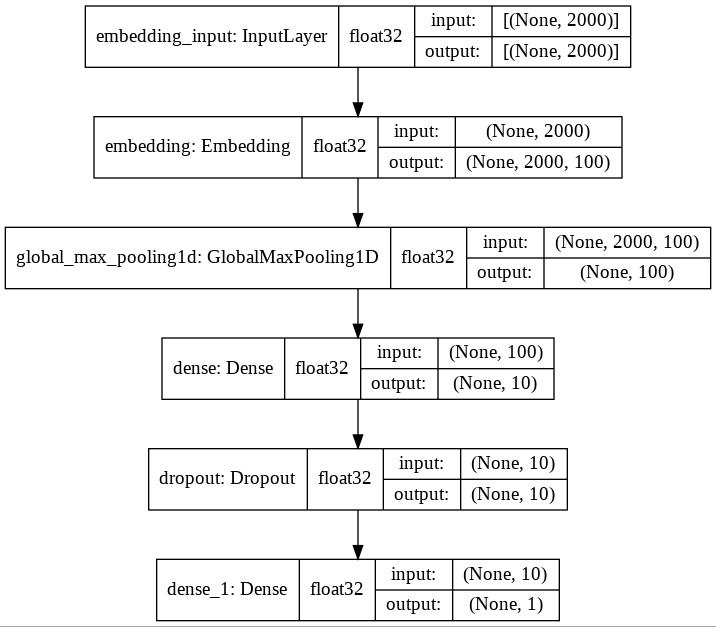

In [29]:
ann.summary()
# Visualise the model another way
plot_model(
    ann,
    to_file=f"{Visuals}ann_1.jpeg",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [30]:
# with tf.device('/device:GPU:0'):
start = perf_counter()
history = ann.fit(x_train, Y_train, epochs=4, validation_data=(x_test,Y_test), validation_steps = len(x_test), steps_per_epoch= len(x_train))
duration_ann = perf_counter() - start
duration_ann = round(duration_ann,2)

Epoch 1/4
4396/4396 [==============================] - 13s 3ms/step - loss: 0.1616 - accuracy: 0.9288 - val_loss: 0.0426 - val_accuracy: 0.9882
Epoch 2/4
4396/4396 [==============================] - 12s 3ms/step - loss: 0.0306 - accuracy: 0.9934 - val_loss: 0.0229 - val_accuracy: 0.9927
Epoch 3/4
4396/4396 [==============================] - 12s 3ms/step - loss: 0.0149 - accuracy: 0.9984 - val_loss: 0.0256 - val_accuracy: 0.9909
Epoch 4/4
4396/4396 [==============================] - 12s 3ms/step - loss: 0.0077 - accuracy: 0.9991 - val_loss: 0.0259 - val_accuracy: 0.9918


In [31]:
ann_history = history 

35/35 [==============================] - 0s 3ms/step - loss: 0.0259 - accuracy: 0.9918
Test Loss:     2.585095725953579 %
Test Accuracy: 99.18107390403748  %
Test error: 0.8189260959625244  %


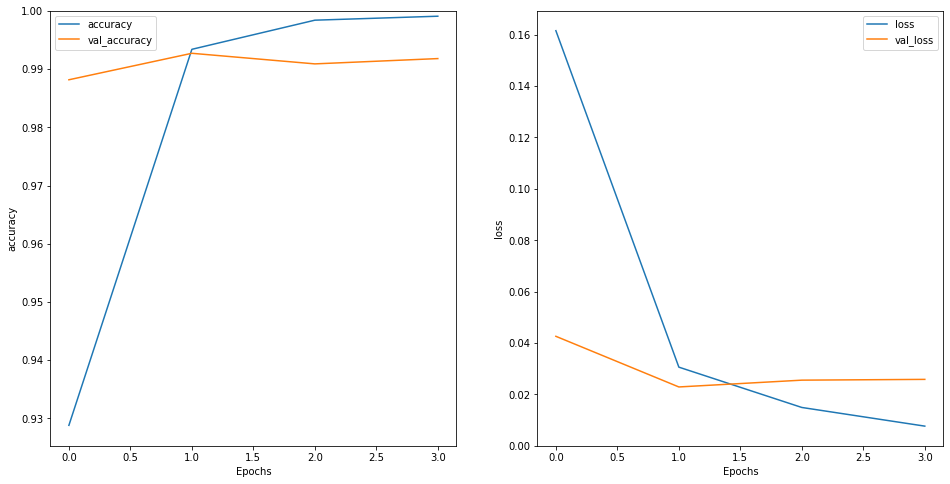

In [32]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.savefig(f"{Visuals}ann_accuracy_loss.jpeg")


# Predicting the Test set results
y_pred = ann.predict(x_test)
y_pred = (y_pred > 0.5)
y_pred_ann = np.array(y_pred)

test_loss_ann, test_acc_ann = ann.evaluate(x_test, Y_test)
test_err_ann = 100 - test_acc_ann*100

print(f"Test Loss:     {test_loss_ann*100} %")
print(f"Test Accuracy: {test_acc_ann*100}  %")
print(f"Test error: {test_err_ann}  %")



AUC: 0.9887987166584953


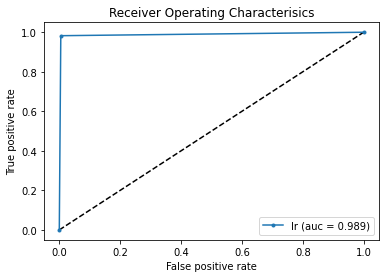

In [33]:
#AUC
lr_auc_ann = ROC_AUC(Y_test, y_pred_ann, f"{Visuals}AUC_ANN")

[[809   4]
 [  5 281]]


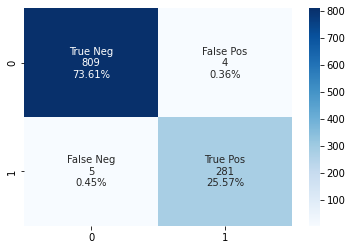

In [34]:
#confusion matrix
get_confusion_matrix_heatmap(Y_test, y_pred_ann, f"{heatmaps}ANN")

First sample of the training data set vectorised 
[ 83 285  48 ...   0   0   0]

First sample of the training data set using index to word : 
university texas conference energy finance february 2001 sherri thanks february vince enron north america corp jeff skilling enron 2000 sent sherri serum enron vince kaminski vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 vince checking date jeff calendar assuming date february holding date whole week trip abroad think flexibility checking back touch soon resolved vince kaminski 2000 jeff skilling corp enron enron vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 jeff friend university texas planning conference energy economics finance february next year would like much keynote speaker given good long term relationship would recommend speak conference talked prof ehud ronn time program think excellent forum present enron accomplishment a

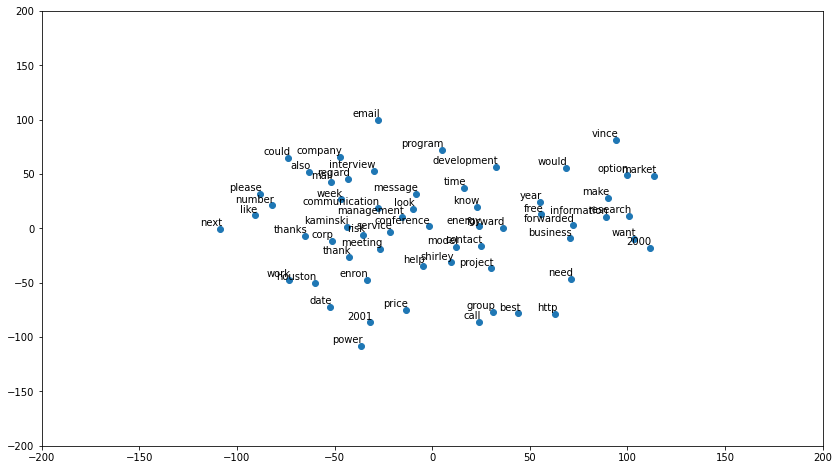

In [35]:
# idx_to_word[0]
# ANN - TSNE - word Embedding visualisations
Word_Embeddings_visualise_TSNE(ann, x_train, idx_to_word, f"{Visuals}ann_Embeddings_1", "embedding", -200, 200, -200, 200, True)

In [36]:
ann.save(f"{Model}ANN.h5")

# **RNN - Recurrent Neural Network with Word Embeddings
Variant used : LSTM : Long short term memory**

In [37]:
"""
RNN - Recurrent Neural Network 
Variant used : LSTM : Long short term memory
"""

rnn = Sequential()
rnn.add(Embedding(input_dim=vocab_size, 
                           output_dim=100, 
                           input_length=2000,
                           # Use masking to handle the variable sequence lengths
                           mask_zero=True))
rnn.add(Dropout(0.2))
# rnn.add(Bidirectional(LSTM(128, activation='relu', input_dim=50)))
rnn.add(Bidirectional(LSTM(100)))
rnn.add(Dense(64, activation='relu'))
# Adding dropout to prevent overfitting
rnn.add(Dropout(0.2))
rnn.add(Dense(1, activation='sigmoid'))
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 100)         2816700   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000, 100)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                12864     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,990,429
Trainable params: 2,990,429
Non-trainable params: 0
____________________________________________

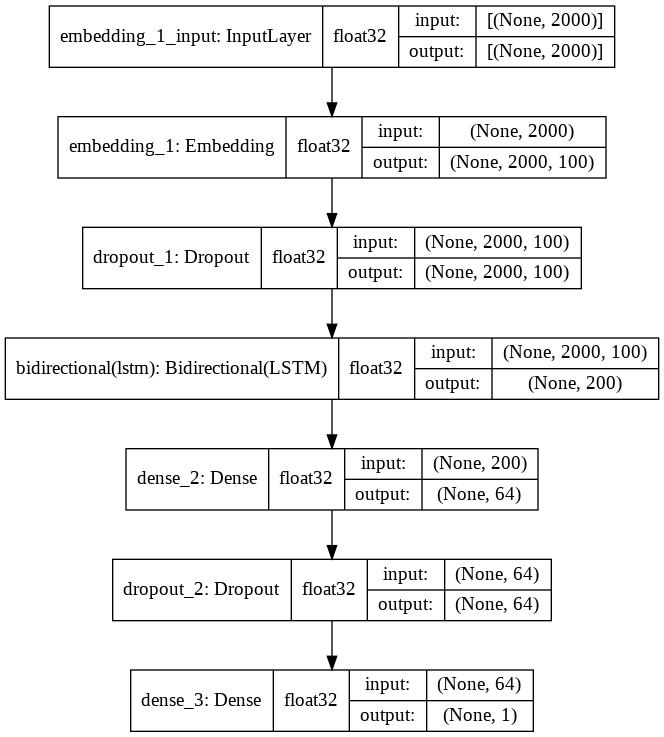

In [38]:
rnn.summary()
plot_model(
    rnn,
    to_file=f"{Visuals}rnn_1.jpeg",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [39]:
# with tf.device('/device:GPU:0'):
start = perf_counter()
history = rnn.fit(x_train, Y_train, epochs=2, validation_data=(x_test, Y_test), validation_steps = len(x_test), steps_per_epoch= len(x_train))
duration_rnn = perf_counter() - start
duration_rnn = round(duration_rnn,2)

Epoch 1/2
4396/4396 [==============================] - 63s 13ms/step - loss: 0.0912 - accuracy: 0.9688 - val_loss: 0.0534 - val_accuracy: 0.9845
Epoch 2/2
4396/4396 [==============================] - 57s 13ms/step - loss: 0.0134 - accuracy: 0.9982 - val_loss: 0.0508 - val_accuracy: 0.9873


In [40]:
rnn_history = history

[[810   3]
 [ 11 275]]


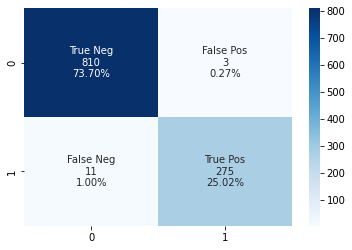

In [41]:
# Predicting the Test set results
y_pred = rnn.predict(x_test)
y_pred = (y_pred > 0.5)

y_pred_rnn = np.array(y_pred)

#confusion matrix
get_confusion_matrix_heatmap(Y_test, y_pred_rnn, f"{heatmaps}RNN")

AUC: 0.9789242123190464


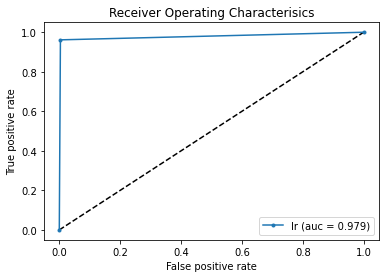

In [42]:
#AUC
lr_auc_rnn = ROC_AUC(Y_test, y_pred_rnn, f"{Visuals}AUC_RNN")

35/35 [==============================] - 3s 24ms/step - loss: 0.0508 - accuracy: 0.9873
Test Loss:     5.075926706194878 %
Test Accuracy: 98.7261176109314  %
Test error: 1.2738823890686035  %


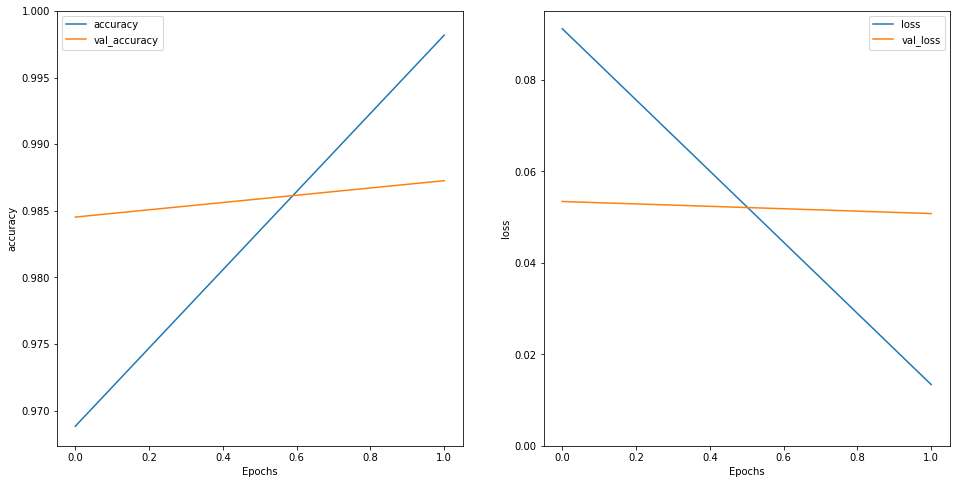

In [43]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.savefig(f"{Visuals}rnn_accuracy_loss.jpeg")

test_loss_rnn, test_acc_rnn = rnn.evaluate(x_test, Y_test)
test_err_rnn = 100 - test_acc_rnn*100

print(f"Test Loss:     {test_loss_rnn*100} %")
print(f"Test Accuracy: {test_acc_rnn*100}  %")
print(f"Test error: {test_err_rnn}  %")

First sample of the training data set vectorised 
[ 83 285  48 ...   0   0   0]

First sample of the training data set using index to word : 
university texas conference energy finance february 2001 sherri thanks february vince enron north america corp jeff skilling enron 2000 sent sherri serum enron vince kaminski vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 vince checking date jeff calendar assuming date february holding date whole week trip abroad think flexibility checking back touch soon resolved vince kaminski 2000 jeff skilling corp enron enron vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 jeff friend university texas planning conference energy economics finance february next year would like much keynote speaker given good long term relationship would recommend speak conference talked prof ehud ronn time program think excellent forum present enron accomplishment a

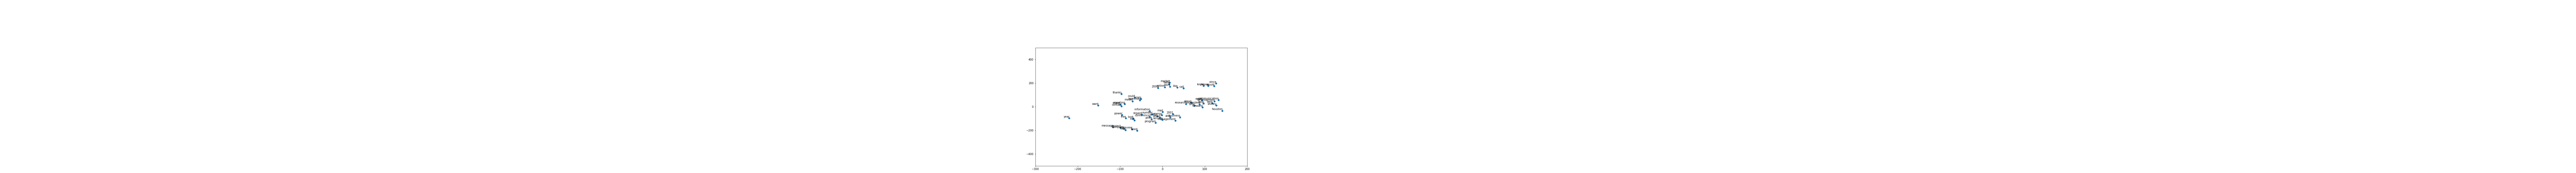

In [44]:
# ANN - TSNE - word Embedding visualisations
Word_Embeddings_visualise_TSNE(rnn, x_train, idx_to_word, f"{Visuals}rnn_Embeddings_1", "embedding_1", -500, 500, -300, 200, True)

In [45]:
rnn.save(f"{Model}RNN.h5")

# ***CNN with Word Embeddings ***
## Input : Embedding vector dim : (Embed Size : 100, max Length of sentences)

In [46]:
"""
CNN without Pretrained Word Embeddings
Input : Embedding vector dim : (Embed Size : 100, max Length of sentences)
"""
# total vocabualry size of dataset
VOCAB_SIZE=vocab_size

# maximum length of each sentence/instance in the dataset
maxLen=2000

# declare keras sequential model
cnn = Sequential()

# initialize first model layer as embedding layer, here we are not using any pretrained word embedding
cnn.add(Embedding(VOCAB_SIZE, 100, input_length=maxLen))

''' --------------------
- initialize second hidden layer as convolutional layer
- number of filters that cnn will return is set to 20
- kernel size is set to 3
- padding is et to valid, which means no padding will be applied
- number of strides is set to default that is 1
-------------------- '''
cnn.add(Conv1D(activation="relu", filters=20, kernel_size=3, padding="valid"))

# we use global max pooling to downsample the features that will simply
# select the maximum values from features representation
# this layer have no parameters because it just have to select max values no
# backpropagation is required
cnn.add(GlobalMaxPooling1D())

# fully connected layer, usually used to change the dimension of the output
# maps all the feature units to mentioned dimension
cnn.add(Dense(units=16))

# output layer, last layer of model must be fully connected layer that will
# map the outputs of previous layer to required output dimension
# as we required only 1 unit for output that will return 0 or 1
# sigmoid activation function will return value between 0 or 1
cnn.add(Dense(1,activation='sigmoid'))

# initialize the optimizer with learning rate 0.001
opt = Adam(learning_rate=0.001)

# model compilation where we defince the loss function and optimizer
cnn.compile( optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 100)         2816700   
_________________________________________________________________
conv1d (Conv1D)              (None, 1998, 20)          6020      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 2,823,073
Trainable params: 2,823,073
Non-trainable params: 0
_________________________________________________________________


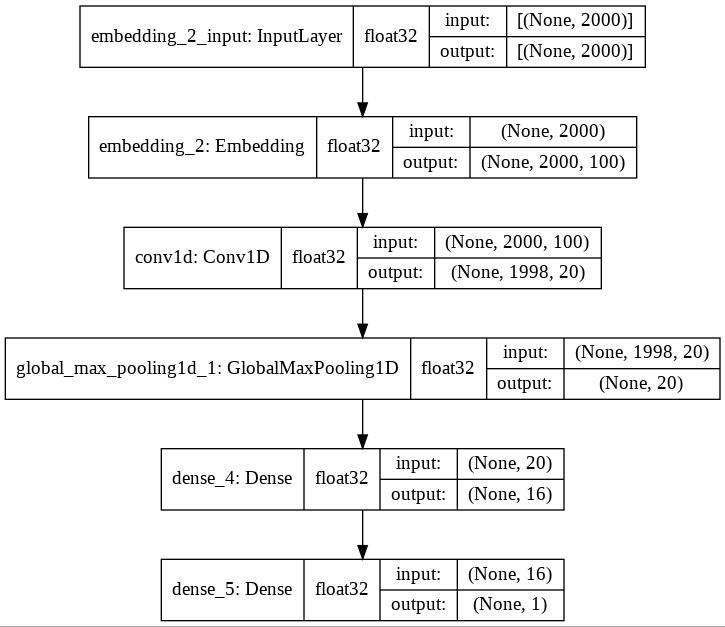

In [47]:
# evaluate trained model performance on test data
cnn.summary()
plot_model(
    cnn,
    to_file=f"{Visuals}cnn_1.jpeg",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [48]:
# start model training
# with tf.device('/device:GPU:0'):
start = perf_counter()
history = cnn.fit(x_train, Y_train, epochs=4, validation_steps = len(x_test), steps_per_epoch= len(x_train), validation_data=(x_test, Y_test), verbose=1)
duration_cnn = perf_counter() - start
duration_cnn = round(duration_cnn,2)

Epoch 1/4
4396/4396 [==============================] - 15s 3ms/step - loss: 0.0818 - accuracy: 0.9677 - val_loss: 0.0312 - val_accuracy: 0.9891
Epoch 2/4
4396/4396 [==============================] - 13s 3ms/step - loss: 0.0067 - accuracy: 0.9970 - val_loss: 0.0230 - val_accuracy: 0.9927
Epoch 3/4
4396/4396 [==============================] - 13s 3ms/step - loss: 3.8712e-04 - accuracy: 0.9998 - val_loss: 0.0194 - val_accuracy: 0.9918
Epoch 4/4
4396/4396 [==============================] - 13s 3ms/step - loss: 8.1488e-05 - accuracy: 1.0000 - val_loss: 0.0354 - val_accuracy: 0.9918


In [49]:
cnn_history = history

[[811   2]
 [  7 279]]


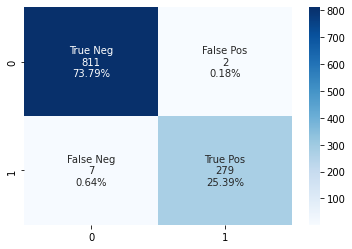

In [50]:
# Predicting the Test set results
y_pred = cnn.predict(x_test)
y_pred = (y_pred > 0.5)
y_pred_cnn = np.array(y_pred)

#confusion matrix
get_confusion_matrix_heatmap(Y_test, y_pred_cnn, f"{heatmaps}CNN")

AUC: 0.9865322254621147


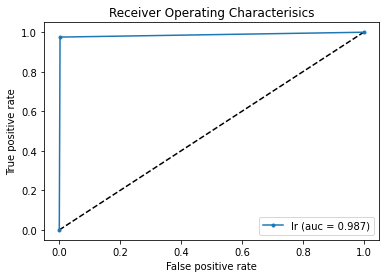

In [51]:
#AUC
lr_auc_cnn = ROC_AUC(Y_test, y_pred_cnn, f"{Visuals}AUC_RNN")

35/35 [==============================] - 0s 3ms/step - loss: 0.0354 - accuracy: 0.9918
Test Loss:     3.541332855820656 %
Test Accuracy: 99.18107390403748  %
Test error: 0.8189260959625244  %


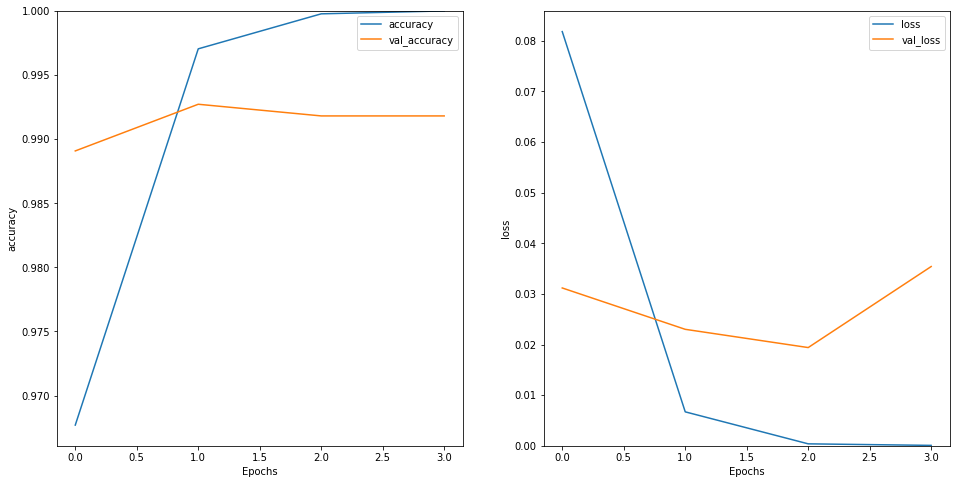

In [52]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.savefig(f"{Visuals}cnn_accuracy_loss.jpeg")


test_loss_cnn, test_acc_cnn = cnn.evaluate(x_test, Y_test)
test_err_cnn = 100 - test_acc_cnn*100

print(f"Test Loss:     {test_loss_cnn*100} %")
print(f"Test Accuracy: {test_acc_cnn*100}  %")
print(f"Test error: {test_err_cnn}  %")

First sample of the training data set vectorised 
[ 83 285  48 ...   0   0   0]

First sample of the training data set using index to word : 
university texas conference energy finance february 2001 sherri thanks february vince enron north america corp jeff skilling enron 2000 sent sherri serum enron vince kaminski vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 vince checking date jeff calendar assuming date february holding date whole week trip abroad think flexibility checking back touch soon resolved vince kaminski 2000 jeff skilling corp enron enron vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 jeff friend university texas planning conference energy economics finance february next year would like much keynote speaker given good long term relationship would recommend speak conference talked prof ehud ronn time program think excellent forum present enron accomplishment a

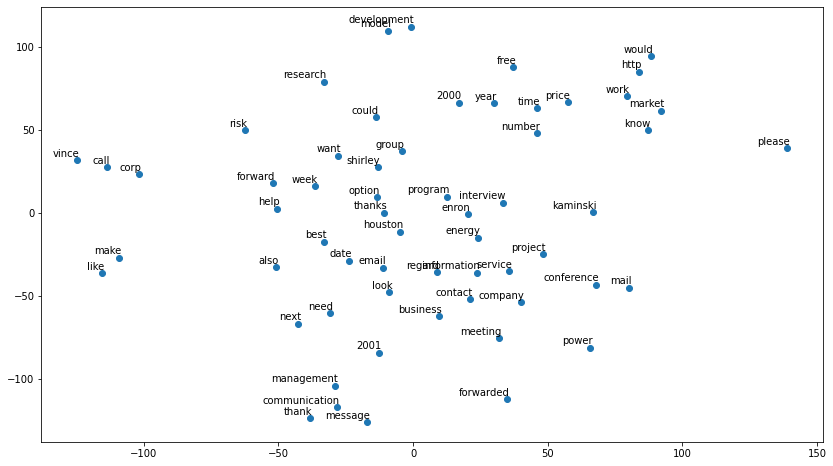

In [53]:
# ANN - TSNE - word Embedding visualisations
Word_Embeddings_visualise_TSNE(cnn, x_train, idx_to_word, f"{Visuals}cnn_Embeddings_1", "embedding_2", 1,1,1,1, False)

In [54]:
cnn.save(f"{Model}CNN.h5")

# Model comparison table with metrics : 
1. Accuracy
2. Loss
3. Error
4. Precision, Recall, F1 score
5. ROC AUC

In [55]:
"""
Model comparison table with metrics : 
1. Accuracy
2. Loss
3. Error
4. Precision, Recall, F1 score
5. ROC AUC
"""
def get_Metrics(y_test, y_pred, average="macro"):
    
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    # find area under curve score
    lr_auc = auc(lr_fpr, lr_tpr)
    precision = precision_score(y_test, y_pred, average = average)
    recall = recall_score(y_test, y_pred, average = average)
    f1_score_ = f1_score(y_test, y_pred, average = average)
    accuracy = accuracy_score(y_test, y_pred)
    #print(f"precision : {precision} recall : {recall} f1_score : {f1_score_} accuracy : {accuracy}")
    return precision, recall, f1_score_, accuracy, lr_auc

ann_acc_t = ann_history.history["accuracy"][len(ann_history.history["accuracy"])-1]
rnn_acc_t = rnn_history.history["accuracy"][len(rnn_history.history["accuracy"])-1]
cnn_acc_t = cnn_history.history["accuracy"][len(cnn_history.history["accuracy"])-1]

Model_comparison = {
    "Ann without pretrained embeddings": {"model":ann, "Train_acc":ann_acc_t, "acc":0, "loss" : 0, "err":0, "lr_auc":0, "f1_score":0, "precision":0, "recall":0, "y_pred":0, "duration":duration_ann },
    "Rnn without pretrained embeddings": {"model":rnn, "Train_acc":rnn_acc_t, "acc":0, "loss" : 0, "err":0, "lr_auc":0, "f1_score":0, "precision":0, "recall":0, "y_pred":0, "duration":duration_rnn },
    "Cnn without pretrained embeddings": {"model":cnn, "Train_acc":cnn_acc_t, "acc":0, "loss" : 0, "err":0, "lr_auc":0, "f1_score":0, "precision":0, "recall":0, "y_pred":0, "duration":duration_cnn }
}

for name, model in Model_comparison.items():
  if name == "Ann without pretrained embeddings":
      model["y_pred"]=y_pred_ann
      print(type(model["y_pred"]))
      print(model["y_pred"].shape)
  if name == "Rnn without pretrained embeddings":
    model["y_pred"]=y_pred_rnn
  if name == "Cnn without pretrained embeddings":
    model["y_pred"]=y_pred_cnn

for name, model in Model_comparison.items():
    y_pred = model["y_pred"]
    y_pred = np.asarray(y_pred)
    precision, recall, f1_score_, accuracy, lr_auc = get_Metrics(Y_test, y_pred)
    if name == "Ann without pretrained embeddings":
      model["acc"]=test_acc_ann
      model["loss"]=test_loss_ann
      model["err"]=test_err_ann
      model["lr_auc"]=lr_auc_ann
      model["f1_score"]=precision
      model["precision"]=recall
      model["recall"]=f1_score_
      
    if name == "Rnn without pretrained embeddings":
      model["acc"]=test_acc_rnn
      model["loss"]=test_loss_rnn
      model["err"]=test_err_rnn
      model["lr_auc"]=lr_auc_rnn
      model["f1_score"]=precision
      model["precision"]=recall
      model["recall"]=f1_score_
    
    if name == "Cnn without pretrained embeddings":
      model["acc"]=test_acc_cnn
      model["loss"]=test_loss_cnn
      model["err"]=test_err_cnn
      model["lr_auc"]=lr_auc_cnn
      model["f1_score"]=precision
      model["precision"]=recall
      model["recall"]=f1_score_
    # print(model)

models_metrics = []
for name, model in Model_comparison.items():
  #print(model["y_pred"].shape)
  precision, recall, f1_score_,  = model["precision"], model["recall"], model["f1_score"]
  accuracy, lr_auc, loss, error = model["acc"], model["lr_auc"], model["loss"], model["err"]
  Train_acc, duration = model["Train_acc"], model["duration"]
  #print(f"precision : {precision} recall : {recall} f1_score : {f1_score_} accuracy : {accuracy}")
  models_metrics.append([name, precision, recall, f1_score_, Train_acc, accuracy, error, loss, lr_auc, duration])

df_metrics = pd.DataFrame(models_metrics)
df_metrics.columns = ['Model', 'Precision', 'Recall', 'f1 score', "Train Accuracy", 'Test Accuracy', 'Error', 'Loss', 'ROC-AUC', 'Train Time (s)']
df_metrics.sort_values(by = 'Test Accuracy', ascending = False, inplace=True)
df_metrics.reset_index(drop = True, inplace=True)
df_metrics.to_csv(f"{Visuals}DNN_Trainable_Embeddings_comparison.csv")
    

<class 'numpy.ndarray'>
(1099, 1)


In [56]:
df_metrics

,Model,Precision,Recall,f1 score,Train Accuracy,Test Accuracy,Error,Loss,ROC-AUC,Train Time (s)
0,Ann without pretrained embeddings,0.988799,0.989353,0.989911,0.99909,0.991811,0.818926,0.025851,0.988799,48.53
1,Cnn without pretrained embeddings,0.986532,0.989304,0.992163,1.00000,0.991811,0.818926,0.035413,0.986532,54.47
2,Rnn without pretrained embeddings,0.978924,0.983305,0.987905,0.99818,0.987261,1.273882,0.050759,0.978924,119.11
